In [1]:
import gym
import collections
import random
import time
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors
from IPython.display import clear_output
import time
import csv
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers import BatchNormalization, Reshape, UpSampling2D, Conv2DTranspose, LeakyReLU, ZeroPadding2D, Input
from keras.layers.convolutional import Conv2D
from keras.layers.recurrent import LSTM, GRU
from keras.models import Sequential, load_model, Model
from keras import regularizers, optimizers
from keras.optimizers import RMSprop, Adam
from keras.models import Sequential, load_model
from keras import regularizers, optimizers
from keras.utils import to_categorical
np.random.seed(1234)
import scipy.io as sio
from skimage.transform import rescale, resize,downscale_local_mean
import scipy as scp
from scipy import stats
import operator
from keras import backend as K
import tensorflow as tf
import os
import keras
from keras.models import load_model
from IPython.display import display, clear_output
from keras.backend.tensorflow_backend import set_session
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= '0'
#config=tf.ConfigProto()
#config.gpu_options.per_process_gpu_memory_fraction=0.5
#set_session(tf.Session(config=config))

Using TensorFlow backend.


In [2]:
 # Deep Q-learning Agent
class DQNAgent:
    def __init__(self,a):
        #(210,160,3),6
        self.drop = 0.5
        self.state_size = (78,75,1)
        self.action_size = 9 # 9 for pacman, 6 for space invader
        self.memory = collections.deque(maxlen=1000000)
        self.gamma = 0.98    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.1
        self.epsilon_decay = 0.999
        self.learning_rate = 10**-4
        self.time_penalty = 1
        self.model = self._build_model()
    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        #model.add(Dense(128, input_shape=self.state_size, activation='relu'))
        #model.add(Dropout(self.drop))
        #model.add(Dense(64, input_shape=self.state_size, activation='relu'))
        #model.add(Dropout(self.drop))
        model.add(Conv2D(16, kernel_size = (8,8), strides = (4,4), padding='valid', input_shape=self.state_size, activation='relu'))
        model.add(Dropout(self.drop))
      
        model.add(Conv2D(32, kernel_size = (4,4) , strides = (2,2), padding='valid',  activation='relu'))
        model.add(Dropout(self.drop))
      
        model.add(Dense(256, activation='relu'))
        model.add(Dropout(self.drop))
        model.add(Flatten())
      
        model.add(Dense(self.action_size, activation='linear'))
       
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        model.summary()
        return model
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done)) #previous state, action, reward after action
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            act_values = np.zeros((1,9))
            return act_values,env.action_space.sample()
        state = np.expand_dims(state,axis=0)
        #print(state.shape)
        act_values = self.model.predict(state)
        #return np.argmax(act_values[0])  # returns action
        return act_values,np.argmax(act_values)   # returns action
    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            state = np.expand_dims(state,axis=0)
            next_state = np.expand_dims(next_state,axis=0)
            target = reward #if we are done the final reward is our target
            if not done: #if we are not done the target is the current reward plut the predicted reward from the next state
                target = reward + self.gamma * np.amax(self.model.predict(next_state)) #two frames ahead
                #print(self.gamma * np.amax(self.model.predict(next_state)))
            target_f = self.model.predict(state) 
            #print(target_f)
            target_f[0][action] = target - self.time_penalty
            #print(target_f)
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [3]:
env = gym.make('Enduro-v0')

(78, 75, 3)

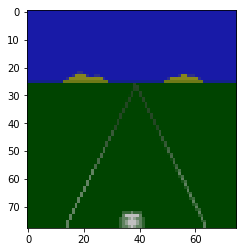

In [4]:
state = env.reset()
next_state, reward, done, info = env.step(1)
lives_before = info['ale.lives']
#env.render()
state = state[0:155,10:160,:]
state_s = rescale(state,(0.5,0.5),multichannel = True,mode = 'constant',anti_aliasing = False)
plt.imshow(state_s)
state_s.shape

#plt.imshow(state_s)

In [5]:
episodes = 1000
stepz = 1000;
reward = 0
death_penalty = 50
total_reward_counter = np.zeros([episodes])
Q_reward_counter = np.zeros([episodes])

# initialize gym environment and the agent
env = gym.make('Enduro-v0')
#env = gym.make('SpaceInvaders-v0')
agent = DQNAgent(env)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 18, 17, 16)        1040      
_________________________________________________________________
dropout_1 (Dropout)          (None, 18, 17, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 7, 32)          8224      
_________________________________________________________________
dropout_2 (Dropout)          (None, 8, 7, 32)          0         
_________________________________________________________________
dense_1 (Dense)              (None, 8, 7, 256)         8448      
_________________________________________________________________
dropout_3 (Dropout)          (None, 8, 7, 256)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 14336)             0         
__________

In [6]:
# Iterate the game
for e in range(episodes):
    total_reward = 0
    
    # reset state in the beginning of each game
    state = env.reset()
    state, reward, done, info = env.step(0)
    state = state[0:155,10:160,:]
    state_s = rescale(state,(0.5,0.5),multichannel = True,mode = 'constant',anti_aliasing = False)
    state_s = state_s[:,:,0]
    state_s = np.expand_dims(state_s,axis=2)
    

    for time_t in range(stepz):
        
        reward_cum = 0
        
        actvals, action = agent.act(state_s)
        if e < 32:
            action = 1
        
        next_state, reward, done, info = env.step(action)
        reward_cum += reward
        #next_state, reward, done, info = env.step(action)
        #reward_cum += reward
        #next_state, reward, done, info = env.step(action)
        #reward_cum += reward
        
        next_state = next_state[0:155,10:160,:]
        next_state_s = rescale(next_state,(0.5,0.5),multichannel = True,mode = 'constant',anti_aliasing = False)

        
        lives_after = info['ale.lives']
        #if reward_cum>0:
        #    reward_cum = 10
        #if lives_after < lives_before:
        #    reward_cum = -death_penalty
            
        next_state_s = next_state_s[:,:,0]
        next_state_s = np.expand_dims(next_state_s,axis=2)
        #print(next_state.shape)
        total_reward = total_reward + reward_cum

        agent.remember(state_s, action, reward, next_state_s, done)
        lives_before = lives_after
        state_s = next_state_s
        
    clear_output(wait=True)
    print("episode: {}/{}, score: {}, epsilon: {}".format(e, episodes, total_reward, agent.epsilon))
                        
    Q_reward_counter[e] = np.max(actvals)
    total_reward_counter[e] = total_reward
       
  
    agent.replay(32)

episode: 233/1000, score: 0.0, epsilon: 0.7920612314455105


KeyboardInterrupt: 

In [ ]:
plt.plot(Q_reward_counter)
plt.axis([0, Q_reward_counter.shape[0], 0, np.max(Q_reward_counter)])


In [ ]:
window = 20
rew_avg = np.empty([episodes])
for pnts in range(window,total_reward_counter.shape[0]):
    rew_avg[pnts] =  np.mean(total_reward_counter[(pnts-window) : pnts+window])
plt.plot(total_reward_counter)
plt.plot(rew_avg)
plt.axis([0, Q_reward_counter.shape[0], 0, np.max(total_reward_counter)])


In [ ]:
total_reward_counter

In [ ]:
#playtest
state = env.reset()
state = state[0:155,10:160,:]

state_s = rescale(state,(0.5,0.5),multichannel = True,mode = 'constant',anti_aliasing = False)
state_vis = state
state_s = state_s[:,:,0]
plt.ion()
fig = plt.figure()

#plt.axis([0, 432, 0, 288])
agent.epsilon = 1;
actgrid = [[0,0,0],[0,0,0],[0,0,0]]
for time_t in range(stepz):
    print(time_t)
    clear_output(wait=True)
    
    state_s = np.expand_dims(state_s,axis=2)
    #print(state_s.shape)
    actvals, action = agent.act(state_s)
    
    actgrid[0][0] = actvals[0][6]
    actgrid[0][1] = actvals[0][1]
    actgrid[0][2] = actvals[0][5]
    
    actgrid[1][0] = actvals[0][3]
    actgrid[1][1] = actvals[0][0]
    actgrid[1][2] = actvals[0][2]
    
    actgrid[2][0] = actvals[0][8]
    actgrid[2][1] = actvals[0][4]
    actgrid[2][2] = actvals[0][7]
    
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(state_vis)

    axarr[1].imshow(actgrid,vmin = np.min(actgrid), vmax = np.max(actgrid))
    
    plt.show()
    
    time.sleep(0.005)
    state, reward, done, _ = env.step(action)
    print(reward)
    print(action)
    #state, reward, done, _ = env.step(0)
    #state, reward, done, _ = env.step(0)
    state = state[0:155,10:160,:]
    state_s = rescale(state,(0.5,0.5),multichannel = True,mode = 'constant',anti_aliasing = False)
    state_vis = state
    state_s = state_s[:,:,0]